In [16]:
%load_ext autoreload
%autoreload 2
from modules import read_and_write
from modules import polyakov
from modules import utility
from modules import fourier_surface
import pandas as pd
import os
import glob


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For reference with integration method the following surface tensions were computed

$z_1$: $\alpha_{o-o} / T^3(\beta=10.85) = 1.2316804724774406$

$z_2$: $\alpha_{o-o} / T^3(\beta=10.85) = 1.5433288477348852$

# Load data

In [69]:
folder_names = ["../data/output-measure-surface/su4-36-36-48-6",
                "../data/output-measure-surface/su4-44-44-64-6/beta-12-twist-2",
                "../data/output-measure-surface/su4-44-44-64-6/beta-10.9-twist-2",
                "../data/output-measure-surface/su4-44-44-64-6/beta-10.85-twist-1",
                "../data/output-measure-surface/su4-44-44-64-6/beta-10.85-twist-2"]
choose_folder = 5
fourier_profiles = {}
folder = folder_names[choose_folder-1]
files = glob.glob(os.path.join(folder, "fourier_profile_*"))
for file in files:
    file_name = file.split("/")[-1]
    smearing_level = file_name.split("_")[-1]
    volume, fourier_profile = read_and_write.read_surface_data(folder, file_name)
    fourier_profiles[smearing_level] = fourier_profile
fourier_profiles = dict(sorted(fourier_profiles.items(), key=lambda item: int(item[0])))
    

In [72]:
utility.display_markdown_title(folder)

# $\text{SU}(4)$, $V$ = ['44', '44', '64', '6'], $\beta=$ 10.85, twist coeff $=$ 2

## Perform post processing

In [70]:
n_2_list = []
f_n_list = []
errors_list = []
for smearing_level, profile in fourier_profiles.items():
    n_2, f_n, errors = utility.compute_with_aa_jackknife_fourier(profile, 10, thermalization=100)
    n_2_list.append(n_2)
    f_n_list.append(f_n)
    errors_list.append(errors)


## Plot Fourier modes for different smearing steps

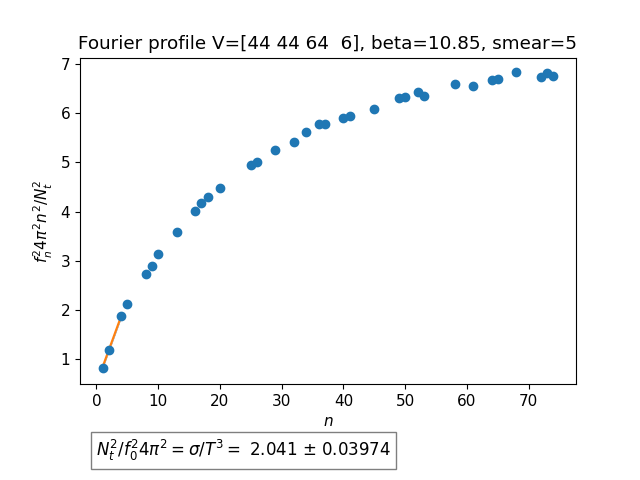

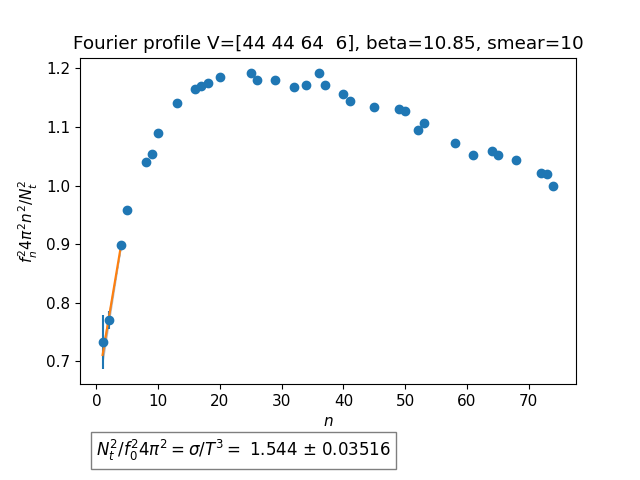

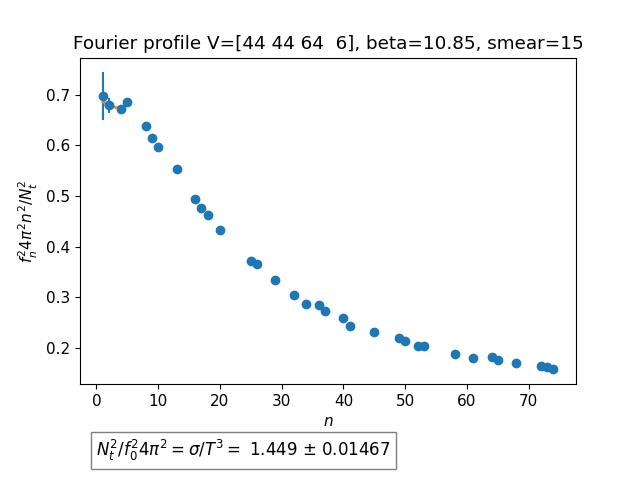

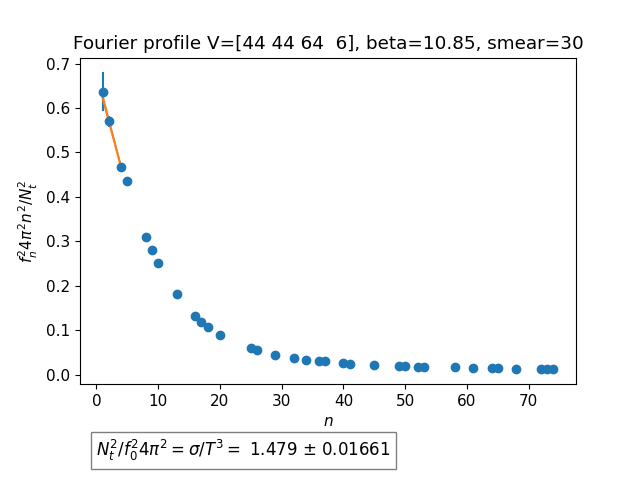

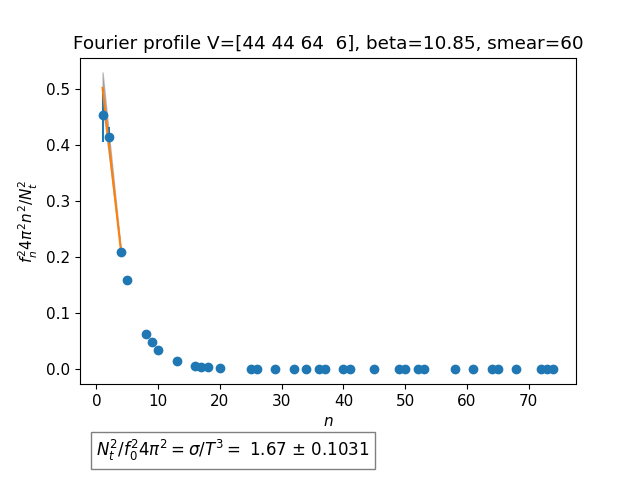

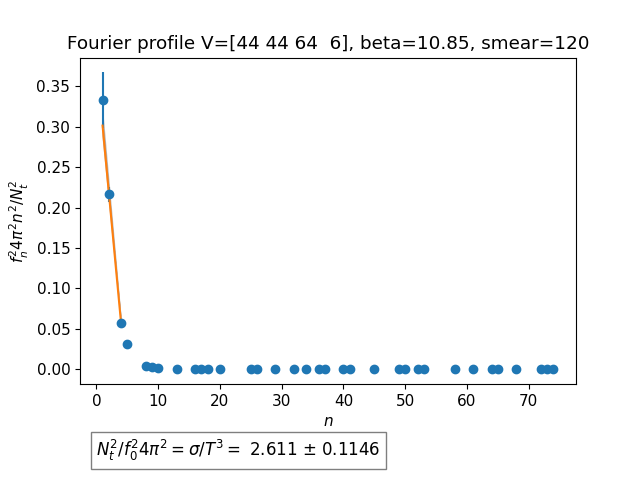

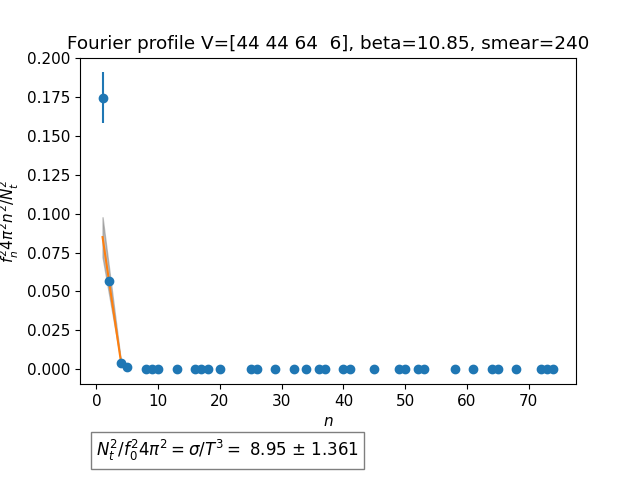

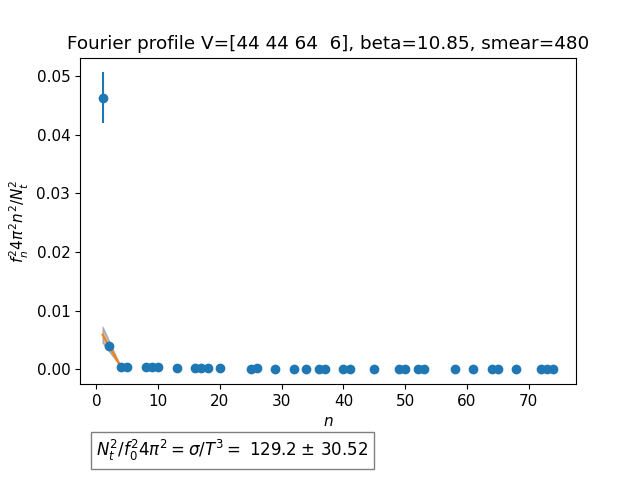

/home/haaaaron/SUN_twist_python_analysis/env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/haaaaron/SUN_twist_python_analysis/modules/fourier_surface.py:93: RuntimeWarning: invalid value encountered in multiply
  return a * np.exp(-b * x) + c
/home/haaaaron/SUN_twist_python_analysis/modules/fourier_surface.py:153: RuntimeWarning: invalid value encountered in matmul


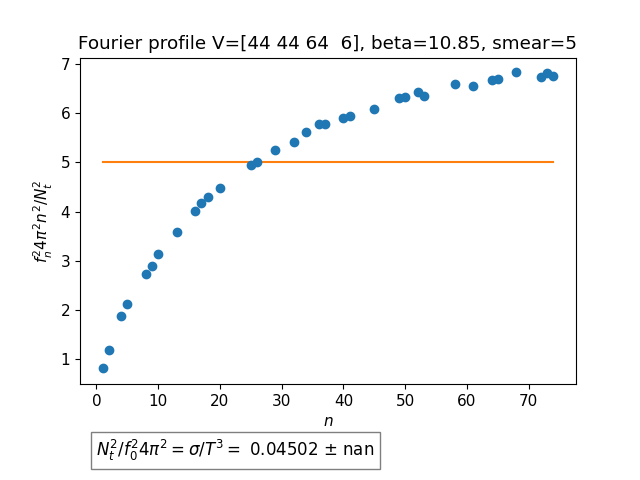

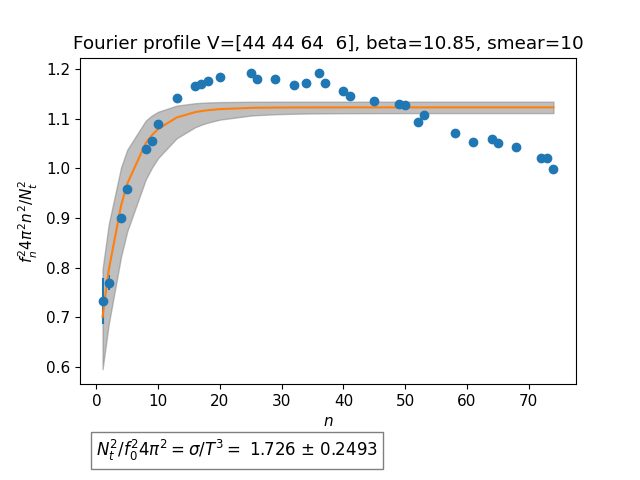

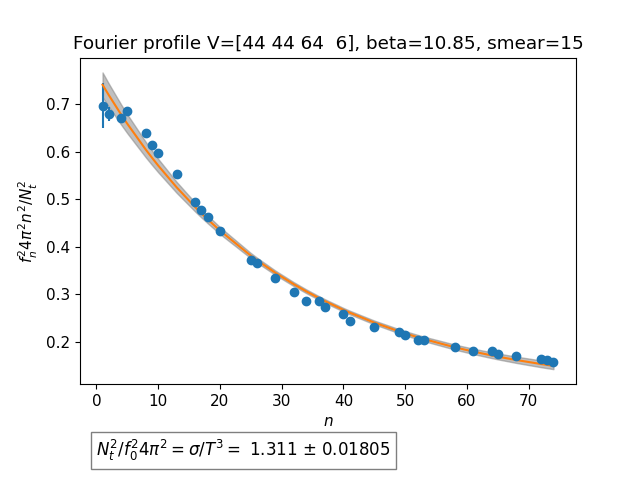

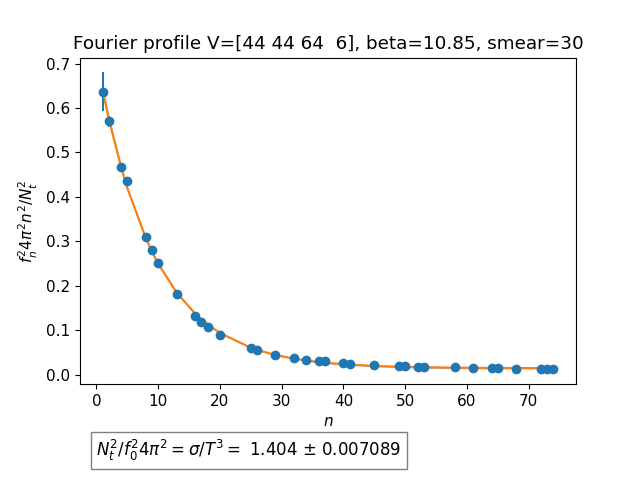

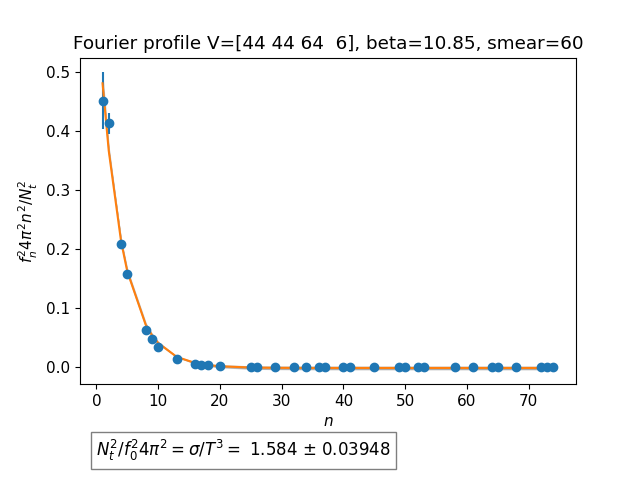

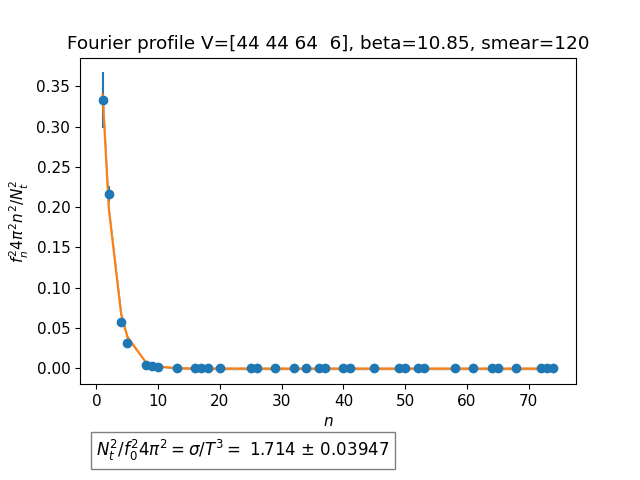

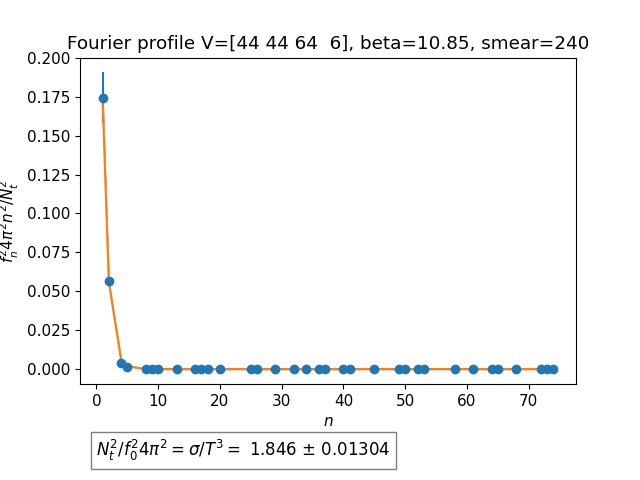

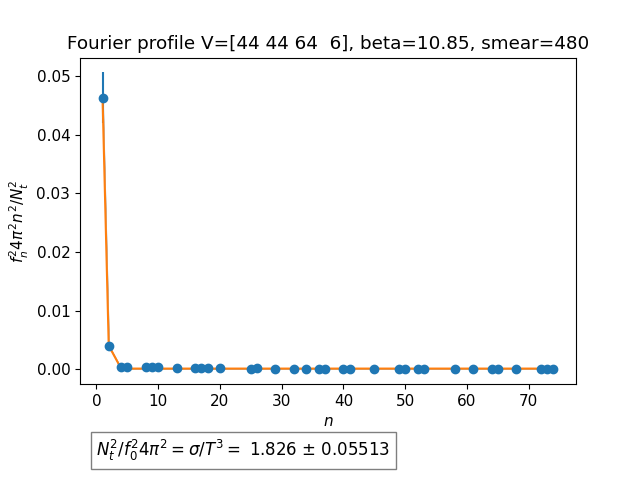

|   smearing | Linear fit ($\sigma / T^3$)   | Exponential fit ($\sigma / T^3$)   |
|-----------:|:------------------------------|:-----------------------------------|
|          5 | 2.041 $\pm$ 0.03974           | 0.04502 $\pm$ nan                  |
|         10 | 1.544 $\pm$ 0.03516           | 1.726 $\pm$ 0.2493                 |
|         15 | 1.449 $\pm$ 0.01467           | 1.311 $\pm$ 0.01805                |
|         30 | 1.479 $\pm$ 0.01661           | 1.404 $\pm$ 0.007089               |
|         60 | 1.67 $\pm$ 0.1031             | 1.584 $\pm$ 0.03948                |
|        120 | 2.611 $\pm$ 0.1146            | 1.714 $\pm$ 0.03947                |
|        240 | 8.95 $\pm$ 1.361              | 1.846 $\pm$ 0.01304                |
|        480 | 129.2 $\pm$ 30.52             | 1.826 $\pm$ 0.05513                |

In [71]:
%matplotlib widget
smearing_levels = list(fourier_profiles.keys())
show_plot = True
data = {
    "smearing": smearing_levels,
    "linear": [
        fourier_surface.compute_fourier_profile(
            n_2, f_n, volume, errors=error, beta=10.85, fit_range=3, smearing=smear, show_plot=show_plot
        ) for n_2, f_n, error, smear in zip(n_2_list, f_n_list, errors_list, smearing_levels)
    ],
    "exponential": [
        fourier_surface.compute_fourier_profile_exponential_fit(
            n_2, f_n, volume, errors=error, beta=10.85, smearing=smear, show_plot=show_plot
        ) for n_2, f_n, error, smear in zip(n_2_list, f_n_list, errors_list, smearing_levels)
    ]
}

df = pd.DataFrame(data)
utility.print_df_as_markdown_fourier_modes(df)

In [45]:
import matplotlib.pyplot as plt

plt.close('all')